# Practical Work 10-1 - GAN for 1D function

Objective: generate a 1D function using a GAN.

We use samples $(x_i,y_i)$ drawn from an analytic function $f$ (i.e. $f(x_i) = y_i$) as real data to train a GAN to reproduce $f$.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PATH_TO_ROOT = "/content/drive/MyDrive/Colab-Notebooks/Deep-Learning-Python/10-gan/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

## Definition of $f$
We assume that the function lives in [-1,1]. The definition of $f$ is up to you

In [ ]:
def f(x):
  return x*x#Just an example: it's up to you !

## Definition of $n$ real samples

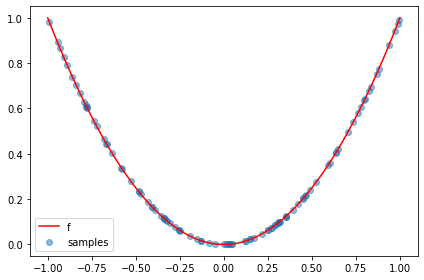

In [ ]:
def real_data(n=100,l=-1,h=1):
    X1 = (l+(h-l)*np.random.random(size=n)).reshape(n,1)
    X2 = f(X1).reshape(n,1)
    X = np.hstack((X1, X2))
    
    y = np.ones((n, 1))
    return X, y
 
x  = np.linspace(-1,1,100)
y = f(x)
plt.plot(x,y,color='red',label='f')
(samples,_)= real_data()
plt.scatter(samples[:, 0], samples[:, 1],alpha=0.5,label='samples')
plt.legend()
plt.tight_layout()

## GAN definition

### Discriminator

In [ ]:
num_hiddenD = 100
def D(n_inputs=2):
    # TODO : MLP with 1 hidden layer, activation ReLU, and output activation sigmoid
    # This is a classification problem for the discriminator (fake/real): the loss is the binary cross-entropy

    input = Input(shape=(n_inputs,))
    x = Dense(num_hiddenD, activation="relu") (input)
    output = Dense(1, activation="sigmoid") (x)
    model = Model(input,output)
    
    adam = Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["acc"])

    return model

### Generator

In [ ]:
num_hiddenG= 30
def G(latent_dim, n_outputs=2):
    # TODO : MLP with 1 hidden layer, activation ReLU, and output activation linear
    # Do not compile the model

    input = Input(shape=(latent_dim,))
    x = Dense(num_hiddenG, activation="relu") (input)
    output = Dense(n_outputs, activation="linear") (x)

    model = Model(input,output)
    return model

In [ ]:
def fake_samples(g, latent_dim, n):
    #TODO : generate n fake examples (X,y) with the generator. Labeled as y = 0
   
    x_input = (np.random.rand(latent_dim * n)).reshape(n , latent_dim)
    X = g.predict(x_input)
    y = np.zeros((n, 1))

    return X, y

### GAN

In [ ]:
def gan(g, d):
    #TODO: put all together, and compile using the binary cross entropy (the whole GAN is a classification problem)
    # The discriminator has not to be trained for the moment, so freeze the corresponding weights.

    model = Sequential()
    model.add(g)
    model.add(d)
    d.trainable=False
    
    adam = Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["acc"])

    return model

## Training

Implement the train procedure with these steps:
1. generate real and fake examples of size batch_size / 2
2. train the discriminator on both datasets using the [train_on_batch](https://keras.io/api/models/model_training_apis/) function
3. train the generator on a dataset consisting of `latent_dim * batch_size`random values labeled by 1
4. The code for tracing the process is given


In [ ]:
def train(g, d, gan, latent_dim, num_epochs=2500, batch_size=128, n_eval=10):
    r_acc = []
    f_acc = []
    # Go though epochs
    for i in range(num_epochs):
        #generate real and fake examples of size batch_size / 2
        x_real, y_real = real_data(int(batch_size/2))
        x_fake, y_fake = fake_samples(g, latent_dim, int(batch_size/2))

        # train the discriminator
        d.train_on_batch(x_real, y_real)
        d.train_on_batch(x_fake, y_fake)

        # train the generator
        x_gan = (np.random.rand(latent_dim * batch_size)).reshape(batch_size, latent_dim)
        y_gan = np.ones((batch_size, 1))

        gan.train_on_batch(x_gan, y_gan)

        # Trace the model every n_eval epochs
        if not((i+1) % n_eval) or i==0:
            n = 100
            x_real, y_real = real_data(n)
            # model evaluation on real examples
            _, real_acc = d.evaluate(x_real, y_real, verbose=0)
            #  fake examples
            x_fake, y_fake = fake_samples(g, latent_dim, n)
            # model evaluation on fake examples
            _, fake_acc = d.evaluate(x_fake, y_fake, verbose=0)
            r_acc.append(real_acc)
            f_acc.append(fake_acc)
            fig = plt.figure(figsize=(16, 6))
        
            ax = fig.add_subplot(111)
            ax.set_xlim(-1,1)
            ax.set_ylim(-0.5,0.5)
            x_f  = np.linspace(-1,1,100)

            y_f = f(x_f)
            plt.plot(x_f,y_f,color='red',lw=3,alpha=0.2)
            plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
            plt.title("GAN at epoch {}".format(i+1))
            plt.savefig('image_at_epoch_{:04d}.png'.format(i+1))
            plt.close()
    plt.figure(figsize=(10,6))
    plt.plot(r_acc,label='real')
    plt.plot(f_acc,label='fake')
    plt.title('Discriminator accuracy on real and fake examples')
    plt.legend
    plt.tight_layout()


## Putting all together

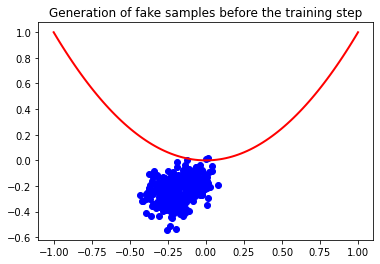

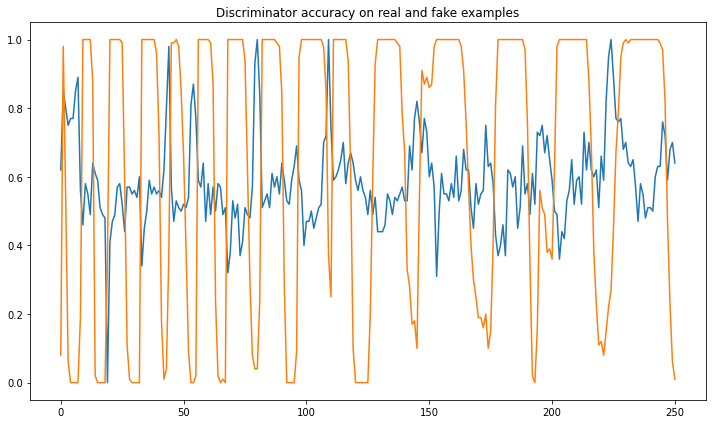

In [ ]:
latent_dim = 5

d = D()
g = G(latent_dim)

fs,_=fake_samples(g, latent_dim,300)
plt.scatter(fs[:, 0], fs[:, 1], color='blue')
plt.plot(x,y,color='red',lw=2)
plt.title("Generation of fake samples before the training step")
plt.show()

mygan = gan(g, d)
train(g, d, mygan, latent_dim)

In [ ]:
anim_file = 'GAN1D.gif'
import imageio
import glob


with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
# to be done 1 time
#!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Output hidden; open in https://colab.research.google.com to view.